I have a csv file with all the date/times of ASTER observations I'm using, and I want to now download all the MODIS (MOD021KM) imagery for the same date/times covering the same spot.

I'm using the Earthdata API because doing this through their web portal would be a slow and cumbersome process.

Some references:
 * [Earthdata API](https://cmr.earthdata.nasa.gov/search/site/docs/search/api.html)
 * [MOD021KM product](https://ladsweb.modaps.eosdis.nasa.gov/missions-and-measurements/products/MOD021KM/)

In [59]:
import requests
import json
import pandas as pd
import io
import glob

Read in ASTER timestamps file

In [60]:
aster = pd.read_csv('aster_AST_L1T_band14_Tuolumne-and-CUES.csv')

Set up some of the granule search criteria for Earthdata search API

In [61]:
url = "https://cmr.earthdata.nasa.gov/search/granules.csv?" #"https://cmr.earthdata.nasa.gov/search/collections?has_granules_created_at\[\]=2015-01-01T19:00:00Z,"

shortname_id = "short_name=MOD021KM" # "short_name=MOD03"
version = "version=6.1"

# bounding box around the Tuolumne area
# lower left longitude, lower left latitude, upper right longitude, upper right latitude
bounding_box = "bounding_box[]=-120,37,-118,38" 

In [62]:
# empty list to hold modis download URLs
modis_urls = []

for i, this_timestamp in enumerate(aster.timestampUTC):
       
    # the date is the first 10 characters of the timestamp string
    date = this_timestamp[:10]
    #print(date)
    
    
    # Terra ASTER/MODIS is always flying over here at ~18:50 UTC (day) or ~5:50 UTC (night)
    hours = [(18, 19), (5, 6)]
    for h in hours:
        start_time = "{date}T{hour_start}:00:00Z".format(date=date,hour_start=h[0])
        end_time = "{date}T{hour_end}:00:00Z".format(date=date,hour_end=h[1])
        time_range = "temporal=" + start_time + "," + end_time
    
        # build the whole request URL and make the request.get
        response = requests.get(url+"&"+shortname_id+"&"+version+"&"+bounding_box+"&"+time_range)
    
        # read the response CSV and put in a temporary dataframe
        df = pd.read_csv(io.StringIO(response.text))
        
        for modis_url in df['Online Access URLs']:
            modis_urls.append(modis_url)

In [63]:
modis_urls

['https://ladsweb.modaps.eosdis.nasa.gov/archive/allData/61/MOD021KM/2017/063/MOD021KM.A2017063.1850.061.2017312092219.hdf',
 'https://ladsweb.modaps.eosdis.nasa.gov/archive/allData/61/MOD021KM/2017/063/MOD021KM.A2017063.0510.061.2017312091343.hdf',
 'https://ladsweb.modaps.eosdis.nasa.gov/archive/allData/61/MOD021KM/2017/079/MOD021KM.A2017079.1850.061.2017313021934.hdf',
 'https://ladsweb.modaps.eosdis.nasa.gov/archive/allData/61/MOD021KM/2017/079/MOD021KM.A2017079.0510.061.2017313020524.hdf',
 'https://ladsweb.modaps.eosdis.nasa.gov/archive/allData/61/MOD021KM/2017/111/MOD021KM.A2017111.1850.061.2017314062948.hdf',
 'https://ladsweb.modaps.eosdis.nasa.gov/archive/allData/61/MOD021KM/2017/111/MOD021KM.A2017111.0510.061.2017314050356.hdf',
 'https://ladsweb.modaps.eosdis.nasa.gov/archive/allData/61/MOD021KM/2017/143/MOD021KM.A2017143.1850.061.2017314142140.hdf',
 'https://ladsweb.modaps.eosdis.nasa.gov/archive/allData/61/MOD021KM/2017/143/MOD021KM.A2017143.0510.061.2017314141235.hdf',


Write the list of URLs out to a text file:

In [65]:
with open("modis_download_list.txt", "w") as output:
    for row in modis_urls:
        output.write(str(row) + '\n')

---
**Download using wget**

`wget --http-user=YOUR_USERNAME --ask-password --keep-session-cookies --auth-no-challenge=on -c -i modis_download_list.txt`

---

**Convert HDF to GeoTiff**

First, get filepaths for the MODIS observations I've just now downloaded:

In [92]:
# search for MODIS files in this directory
modis_dir = '/storage/MODIS/Tuolumne_MOD021KM/'
# get .hdf files here
modis_filelist = glob.glob(modis_dir + '*.hdf', recursive=True)

In [93]:
import rioxarray
from pyproj import Transformer
from affine import Affine
from rioxarray.rioxarray import affine_to_coords

def modis_hdf2geotiff(modis_filename, modis_variable, output_filename):
    
    '''Convert a MODIS HDF file to GeoTiff and reproject following this method: https://gis.stackexchange.com/questions/345691/using-python-gdal-to-reproject-an-hdf'''
    
    modis_crs_str = "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +units=m +no_defs"
    
    rds = rioxarray.open_rasterio(modis_filename,
                                  variable=[modis_variable],
                                  parse_coordinates=False)
    
    transformer = Transformer.from_crs("EPSG:4326", modis_crs_str, always_xy=True)
    west, north = transformer.transform(rds.WESTBOUNDINGCOORDINATE, rds.NORTHBOUNDINGCOORDINATE)
    
    pixel_size = 1000 # 1 km
    transform = Affine(pixel_size, 0, west, 0, -pixel_size, north)
    
    coords = affine_to_coords(transform, rds.rio.width, rds.rio.height)
    rds.coords["x"] = coords["x"]
    rds.coords["y"] = coords["y"]
    
    # add the CRS
    rds.rio.write_crs(modis_crs_str, inplace=True)
    
    rds4326 = rds.rio.reproject("EPSG:4326")
    
    # write out to geotiff file
    rds4326[modis_variable].rio.to_raster(output_filename)
    
    return None

In [ ]:
modis_variable = "4"

for i in range(len(modis_filelist)):
    fn = "{}".format(modis_filelist[i])
    new_fn = "{}.tif".format(modis_filelist[i][:-4])
    print('\nConverting {} to {}\n'.format(fn, new_fn))
    modis_hdf2geotiff(fn, modis_variable, new_fn)

---
---
---
---

In [140]:
from osgeo import gdal
import numpy as np
import os

In [157]:
hdf_file = modis_filelist[0]
subdataset = 0
band = 10
dst_dir = './'

In [158]:
""" Writes MODIS remote sensing HDF file to GeoTiff """

# open the dataset
hdf_ds = gdal.Open(hdf_file, gdal.GA_ReadOnly)
band_ds = gdal.Open(hdf_ds.GetSubDatasets()[subdataset][0], gdal.GA_ReadOnly)


In [159]:
band_ds

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7fcaa1147e70> >

In [160]:

# read into numpy array
band_array = band_ds.ReadAsArray().astype(np.int16)



In [161]:
# convert no_data values
#band_array[band_array == -28672] = -32768


In [162]:

# build output path
band_path = os.path.join(dst_dir, os.path.basename(os.path.splitext(hdf_file)[0]) + "-sd" + str(subdataset+1) + ".tif")


In [163]:

# write raster
out_ds = gdal.GetDriverByName('GTiff').Create(band_path,
                                              band_ds.RasterXSize,
                                              band_ds.RasterYSize,
                                              1,  #Number of bands
                                              gdal.GDT_Int16,
                                              ['COMPRESS=LZW', 'TILED=YES'])

out_ds.SetGeoTransform(band_ds.GetGeoTransform())
out_ds.SetProjection(band_ds.GetProjection())
out_ds.GetRasterBand(1).WriteArray(band_array[band])
out_ds.GetRasterBand(1).SetNoDataValue(-32768)
print("Successfully wrote:" + band_path)

out_ds = None  #close dataset to write to disc

Successfully wrote:./MOD021KM.A2017063.1850.061.2017312092219-sd1.tif


In [104]:
modis_filename = modis_filelist[0]
modis_variable = "4"
output_filename = "test9.tif"

In [105]:
modis_crs_str = "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +units=m +no_defs"

In [106]:
rds = rioxarray.open_rasterio(modis_filename,
                              variable=[modis_variable],
                              parse_coordinates=False)

/home/spestana/opt/anaconda3/envs/goes-linux/lib/python3.6/site-packages/rasterio/__init__.py:219: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [111]:
rds

<xarray.Dataset>
Dimensions:      (band: 16, x: 1354, y: 2030)
Coordinates:
  * band         (band) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16
    spatial_ref  int64 0
Dimensions without coordinates: x, y
Data variables:
    4            (band, y, x) uint16 ...
Attributes:
    % Dead Detector EV Data:                                     0, 0, 0, 0, ...
    % Dead Subframe EV Data:                                     0, 0, 0, 0, ...
    % EV Data Not Calibrated:                                    0, 0, 0, 0, ...
    % EV Data Where Cannot Compute BG DN:                        0, 0, 0, 0, ...
    % EV Data Where Nadir Door Closed:                           0, 0, 0, 0, ...
    % L1A EV All Scan Data are Missing:                          0
    % L1A EV DN Missing Within Scan:                             0, 0, 0, 0, ...
    % L1A EV RSB DN Not in Day Mode:                             0, 0, 0, 0, ...
    % RSB EV Data With dn** Below Scale:                         0, 0, 0, 0, ...
    % Sat

In [97]:
#transformer = Transformer.from_crs("EPSG:4326", modis_crs_str, always_xy=True)
#west, north = transformer.transform(rds.WESTBOUNDINGCOORDINATE, rds.NORTHBOUNDINGCOORDINATE)

In [98]:

#pixel_size = 1000 # 1 km
#transform = Affine(pixel_size, 0, west, 0, -pixel_size, north)

In [99]:
#coords = affine_to_coords(transform, rds.rio.width, rds.rio.height)
#rds.coords["x"] = coords["x"]
#rds.coords["y"] = coords["y"]

In [100]:
#rds

In [101]:
# add the CRS
rds.rio.write_crs(modis_crs_str, inplace=True)

<xarray.Dataset>
Dimensions:      (band: 16, x: 1354, y: 2030)
Coordinates:
  * band         (band) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16
    spatial_ref  int64 0
Dimensions without coordinates: x, y
Data variables:
    4            (band, y, x) uint16 ...
Attributes:
    % Dead Detector EV Data:                                     0, 0, 0, 0, ...
    % Dead Subframe EV Data:                                     0, 0, 0, 0, ...
    % EV Data Not Calibrated:                                    0, 0, 0, 0, ...
    % EV Data Where Cannot Compute BG DN:                        0, 0, 0, 0, ...
    % EV Data Where Nadir Door Closed:                           0, 0, 0, 0, ...
    % L1A EV All Scan Data are Missing:                          0
    % L1A EV DN Missing Within Scan:                             0, 0, 0, 0, ...
    % L1A EV RSB DN Not in Day Mode:                             0, 0, 0, 0, ...
    % RSB EV Data With dn** Below Scale:                         0, 0, 0, 0, ...
    % Sat

In [103]:
rds4326 = rds.rio.reproject("EPSG:4326")

CPLE_AppDefinedError: The transformation is already "north up" or a transformation between pixel/line and georeferenced coordinates cannot be computed for <VRTDataset rasterXSize="1354" rasterYSize="2030"><VRTRasterBand /><SRS>PROJCS["unknown",GEOGCS["unknown",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]</SRS><GeoTransform>0.0,1.0,0.0,0.0,0.0,1.0</GeoTransform></VRTDataset>. There is no affine transformation and no GCPs. Specify transformation option SRC_METHOD=NO_GEOTRANSFORM to bypass this check.

In [86]:
# write out to geotiff file
rds4326[modis_variable].rio.to_raster(output_filename)

In [87]:
import xarray as xr
import rioxarray

In [89]:
ds = xr.open_rasterio('test8.tif')

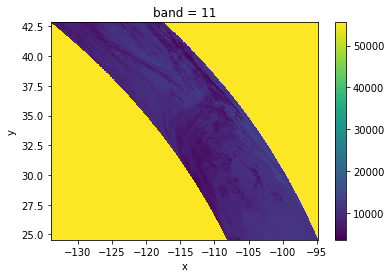

In [91]:
ds[10].plot()

In [76]:
# Try converting with gdalwarp following this method: https://gis.stackexchange.com/questions/194533/convert-modis-hdf-file-in-sinusoidal-projection-into-geotiff-with

#for i in range(len(modis_filelist)):
#    fn = "\"{}\"".format(modis_filelist[i])
#    new_fn = "\"{}.tif\"".format(modis_filelist[i][:-4])
#    print('\nConverting {} to {}\n'.format(fn, new_fn))
#    !gdalwarp -of GTIFF -s_srs '+proj=sinu +R=6371007.181 +nadgrids=@null +wktext' -r cubic -t_srs '+proj=longlat +datum=WGS84 +no_defs' HDF4_SDS:UNKNOWN:$fn:4 $new_fn